# A comparison of the instrument noise calculation in Tools21cm with 21cmSense

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
from tqdm import tqdm
from glob import glob
from time import time

In [3]:
from astropy import units as un
from astropy.cosmology import Planck15

## 21cmSense

In [9]:
import py21cmsense as p21sense
from py21cmsense.observatory import Observatory
from py21cmsense.sensitivity import PowerSpectrum
from py21cmsense.theory import EOS2021

Here we define some helper functions. `get_senses` is a function that takes in a `21cmSense.Observation` instance, the frequency bands of the survey, as well as the $k_\bot, k_\parallel$ bins at which we want the sensitivities. This function simply loops over each band and calculates the sensitivity of the given observation at that band and $k_\bot, k_\parallel$ bins.

In [10]:
def freq2z(f):
    """Convert frequency in MHz to redshift."""
    return 1420.4 / f - 1.0


def z2freq(z):
    """Convert redshift to frequency in MHz."""
    return 1420.4 / (z + 1.0)


def get_senses(
    observation,
    freq_bands,
    kperp_edges_hmpc,
    kpar_edges_hmpc,
    calc_2d=False,
    foreground_model="moderate",
    theory_model=EOS2021,
    **kwargs,
):
    """Calculate the sensitivity for a set of frequency bands."""
    h = observation.cosmo.H0.value / 100.0
    redshifts = kwargs["redshifts"]
    mock_senses = {}
    mock_senses["kperp_edges_hMpc"] = kperp_edges_hmpc
    mock_senses["kpar_edges_hMpc"] = kpar_edges_hmpc
    mock_senses["redshifts"] = redshifts
    mock_senses["freq_bands"] = freq_bands
    mock_senses["h"] = h

    for _i, band, zval in zip(range(len(freq_bands)), freq_bands, redshifts):
        this_z = {}
        band_name = str(np.round(band, 1)) + " MHz"

        sense = PowerSpectrum(
            observation=observation, foreground_model=foreground_model, theory_model=theory_model()
        ).at_frequency(band * un.MHz)
        if calc_2d:
            sense2d_sample = sense.calculate_sensitivity_2d_grid(
                kperp_edges=kperp_edges_hmpc, kpar_edges=kpar_edges_hmpc, thermal=False, sample=True
            )
            this_z["sample_2D_mK2"] = sense2d_sample.value

            sense2d_thermal = sense.calculate_sensitivity_2d_grid(
                kperp_edges=kperp_edges_hmpc, kpar_edges=kpar_edges_hmpc, thermal=True, sample=False
            )
            this_z["thermal_2D_mK2"] = sense2d_thermal.value

            both = np.sqrt(sense2d_sample.value**2 + sense2d_thermal.value**2)
            this_z["sample_and_thermal_2D_mK2"] = both

        sense1d_sample = sense.calculate_sensitivity_1d(thermal=False, sample=True)
        this_z["sample_1D_mK2"] = sense1d_sample.value
        this_z["theory_1D_mK2"] = sense.theory_model.delta_squared(
            zval, sense.k1d.value * mock_senses["h"]
        ).value

        this_z["k_1D_Mpc"] = sense.k1d.value * mock_senses["h"]
        sense1d_thermal = sense.calculate_sensitivity_1d(thermal=True, sample=False)
        this_z["thermal_1D_mK2"] = sense1d_thermal.value

        sense1d_both = sense.calculate_sensitivity_1d(thermal=True, sample=True)
        this_z["sample_and_thermal_1D_mK2"] = sense1d_both.value
        mock_senses[band_name] = this_z
    return mock_senses


### Define the Observatories for each SKA configuration

We will produce sensitivity estimates for two SKA configurations: AA* and AA4.

In [11]:
aaast = Observatory.from_ska("AA*")
aa4 = Observatory.from_ska("AA4")

The two configurations differ from each other in the following ways:  
- **AA4** has more stations (512) than **AA*** (307).  
- **AA4** has more stations clustered at the center than **AA***.  

Let’s check this by plotting the station layouts of each experiment:

AA* has 307 antennas
AA4 has 512 antennas


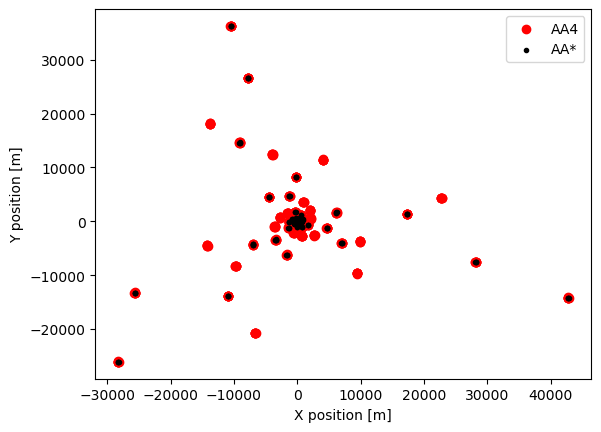

In [12]:
aaast_antpos = aaast.antpos.value[:, :2]  # exclude z position
aa4_antpos = aa4.antpos.value[:, :2]  # exclude z position
print("AA* has", aaast_antpos.shape[0], "antennas")
print("AA4 has", aa4_antpos.shape[0], "antennas")
plt.scatter(aa4_antpos[:, 0], aa4_antpos[:, 1], label="AA4", color="r")
plt.scatter(aaast_antpos[:, 0], aaast_antpos[:, 1], label="AA*", color="k", marker=".")
plt.legend()
plt.ylabel("Y position [m]")
plt.xlabel("X position [m]")
plt.show()

We can also plot the baseline distribution produced by each experiment:

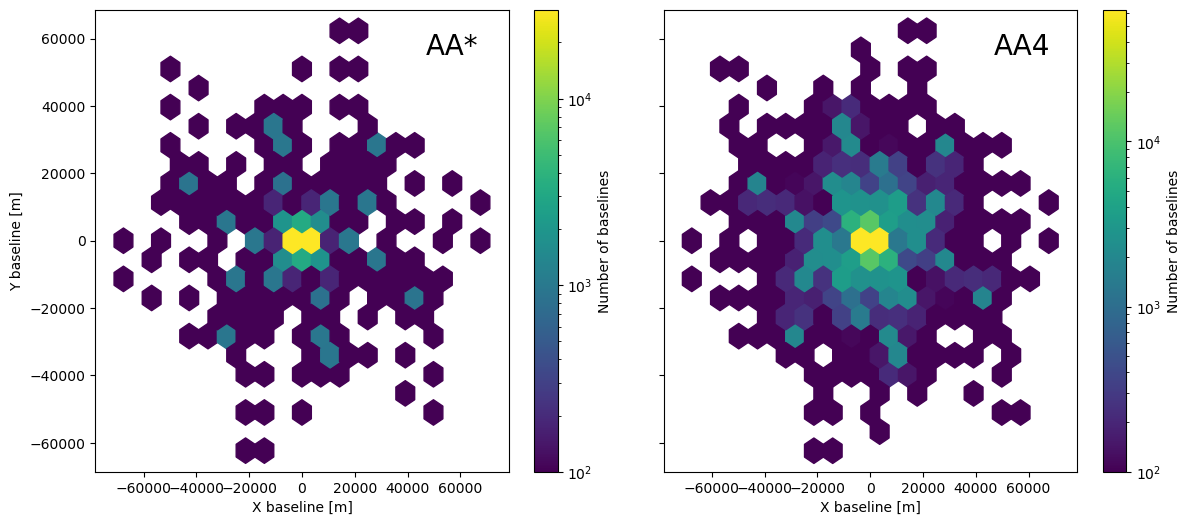

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
im = ax[0].hexbin(
    aaast.baselines_metres[:, :, 0].ravel(),
    aaast.baselines_metres[:, :, 1].ravel(),
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
im = ax[1].hexbin(
    aa4.baselines_metres[:, :, 0].ravel(),
    aa4.baselines_metres[:, :, 1].ravel(),
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.8, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top")
plt.show()

## Tools21cm

In [4]:
import tools21cm as t2c

In [ ]:
from itertools import combinations

def antenna_positions_to_baselines(antxyz):
    baselines = [np.abs(a1-a2) for a1,a2 in tqdm(combinations(antxyz, 2))]
    return np.array(baselines)

In [5]:
aastar_layout = t2c.get_SKA_Low_layout(subarray_type="AA*")
aa4_layout = t2c.get_SKA_Low_layout(subarray_type="AA4")

AA* contains 307 antennae.
AA4 contains 512 antennae.


(307, 3)
(512, 3)


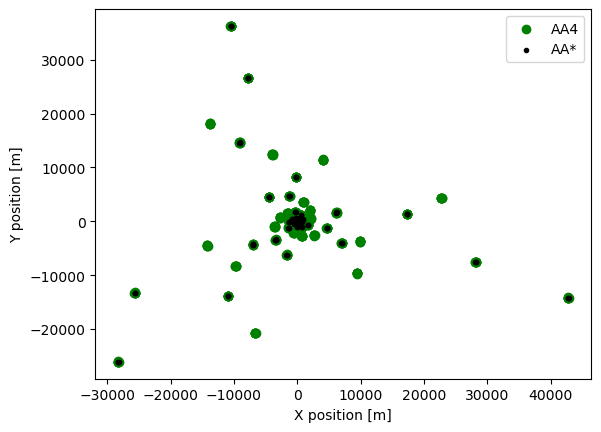

In [7]:
print(aastar_layout.shape)
print(aa4_layout.shape)

plt.scatter(aa4_layout[:, 0], aa4_layout[:, 1], label="AA4", color="g")
plt.scatter(aastar_layout[:, 0], aastar_layout[:, 1], label="AA*", color="k", marker=".")
plt.legend()
plt.ylabel("Y position [m]")
plt.xlabel("X position [m]")
plt.show()

In [21]:
aaast.baselines_metres[:,:,0]

<Quantity [[    0.        ,  -307.48623203,     2.08723344, ...,
            -1824.70995072, -1771.15625333, -1834.95073009],
           [  307.48623203,     0.        ,   309.57346547, ...,
            -1517.22371869, -1463.6700213 , -1527.46449806],
           [   -2.08723344,  -309.57346547,     0.        , ...,
            -1826.79718417, -1773.24348677, -1837.03796353],
           ...,
           [ 1824.70995072,  1517.22371869,  1826.79718417, ...,
                0.        ,    53.55369739,   -10.24077937],
           [ 1771.15625333,  1463.6700213 ,  1773.24348677, ...,
              -53.55369739,     0.        ,   -63.79447676],
           [ 1834.95073009,  1527.46449806,  1837.03796353, ...,
               10.24077937,    63.79447676,     0.        ]] m>

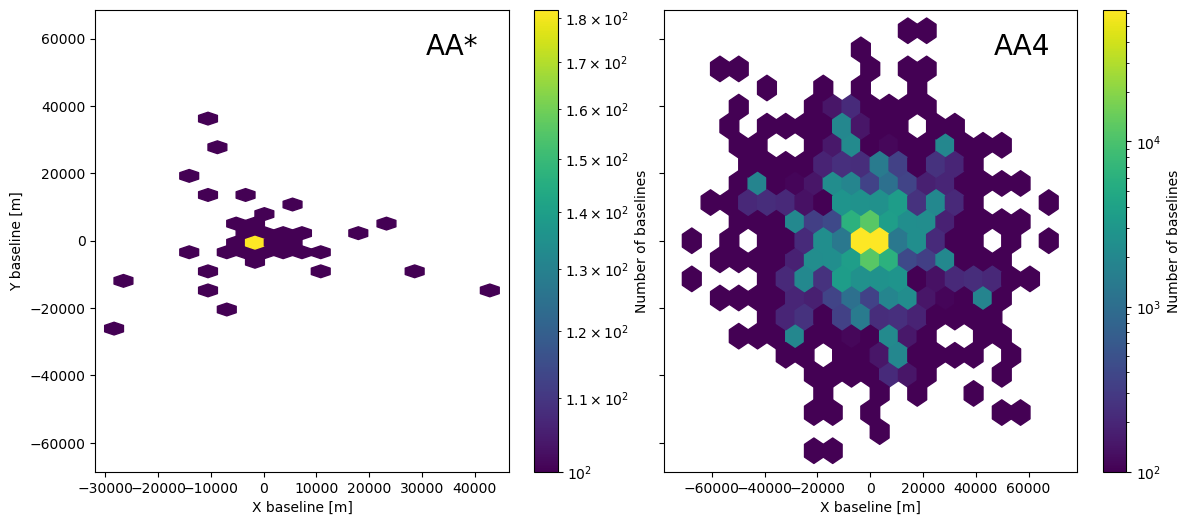

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
im = ax[0].hexbin(
    aa4_layout[:, 0], 
    aa4_layout[:, 1],
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
im = ax[1].hexbin(
    aa4.baselines_metres[:, :, 0].ravel(),
    aa4.baselines_metres[:, :, 1].ravel(),
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.8, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top")
plt.show()